In [16]:
# 1. Import Libraries
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import evaluate

In [17]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Define model paths
MODEL_BASE      = "../models/whisper_tiny_de"
MODEL_FINETUNED = "../models/whisper_tiny_de_finetuned"

# Load shared processor (from base)
processor = WhisperProcessor.from_pretrained(MODEL_BASE)

# Load base model
model_base = WhisperForConditionalGeneration.from_pretrained(
    MODEL_BASE
).to("mps")

# Load fine-tuned model
model_finetuned = WhisperForConditionalGeneration.from_pretrained(
    MODEL_FINETUNED
).to("mps")

In [18]:
from datasets import load_dataset, Audio

common_voice = load_dataset(
    "mozilla-foundation/common_voice_13_0",
    "de",
    split={
        "train": "train",          # full train
        "validation": "validation",# full validation
        "test": "test"             # full test
    },
    trust_remote_code=True
)

for split in common_voice:
    common_voice[split] = common_voice[split].cast_column("audio", Audio(sampling_rate=16000))

print(common_voice)
print(common_voice["train"][0])

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 540437
    })
    validation: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 16143
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 16143
    })
})
{'client_id': '2a2542c35dd80feb743539a32e8c856a4bfce196ae633b0d71c4c4d1b988720c795a9c3f8c38a0af7ba9e366e6431527688cc21c8bb5c88f437c311ce518b51b', 'path': '/Users/vietphung/.cache/huggingface/datasets/downloads/extracted/4411fd7718fbccd84e4c91d664f30afa1ab4b843252733e6dc8f12ecce391a4b/de_train_0/common_voice_de_19130994.mp3', 'audio': {'path': '/Users/vietphung/.cache/huggingface

In [20]:
ex = common_voice["train"][0]

audio = ex["audio"]["array"]
print("Ground truth:", ex["sentence"])

inputs = processor(
    audio,
    sampling_rate=16000,
    return_tensors="pt"
).to("mps")

with torch.no_grad():
    generated_ids = model_finetuned.generate(
        inputs.input_features,
        pad_token_id=processor.tokenizer.eos_token_id,
        generation_config=model_finetuned.generation_config
    )

pred = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Prediction:", pred)

Ground truth: Damit war das erklärte Ziel des Teams verfehlt.
Prediction: Damit war das erklärtet Ziel des Teams verfehlt.


In [21]:
from IPython.display import Audio

# Nghe lại file audio gốc
Audio(ex["audio"]["array"], rate=16000)

In [25]:
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")


def evaluate_model(model, processor, dataset, num_samples=50, device="mps"):
    """
    Evaluate model on WER, CER using a subset of dataset.
    """
    refs, preds, audios = [], [], []
    subset = dataset.select(range(num_samples))
    for ex in subset:
        audio = ex["audio"]["array"]
        audios.append(audio)  # để test nghe lại
        inputs = processor(
            audio,
            sampling_rate=16000,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            generated_ids = model.generate(
                inputs.input_features,
                pad_token_id=processor.tokenizer.eos_token_id,  # ✅ thêm pad_token_id
                generation_config=model.generation_config
            )
        pred = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        refs.append(ex["sentence"])
        preds.append(pred)

    wer = wer_metric.compute(predictions=preds, references=refs)
    cer = cer_metric.compute(predictions=preds, references=refs)
    return wer, cer, preds[:5], refs[:5], audios[:5]

In [29]:
def evaluate_split(split_name, split_data, processor, model_base, model_finetuned, device="mps"):
    """
    Compare WER/CER between Base and Fine-tuned models for one dataset split.
    """
    results = {}

    # Base model evaluation
    wer_b, cer_b, preds_b, refs_b, audios_b = evaluate_model(
        model_base, processor, split_data, num_samples=50, device=device
    )
    results["base"] = {
        "wer": wer_b,
        "cer": cer_b,
        "preds": preds_b,
        "refs": refs_b,
        "audios": audios_b,
    }

    # Fine-tuned model evaluation
    wer_f, cer_f, preds_f, refs_f, audios_f = evaluate_model(
        model_finetuned, processor, split_data, num_samples=50, device=device
    )
    results["finetuned"] = {
        "wer": wer_f,
        "cer": cer_f,
        "preds": preds_f,
        "refs": refs_f,
        "audios": audios_f,
    }

    # Print summary
    print(f"\n=== {split_name} Split ===")
    print(f"Base      - WER: {wer_b:.4f}, CER: {cer_b:.4f}")
    print(f"Fine-tuned- WER: {wer_f:.4f}, CER: {cer_f:.4f}")

    return results


# Evaluate on Train / Validation / Test splits
all_results = {}
for split_name, split_data in {
    "Train": common_voice["train"],
    "Validation": common_voice["validation"],
    "Test": common_voice["test"],
}.items():
    all_results[split_name] = evaluate_split(
        split_name, split_data, processor, model_base, model_finetuned
    )

# Show one example from Test split with audio playback for REF/Base/Fine-tuned
from IPython.display import Audio, display

print("\n=== Example from Test Split ===")
i = 0  # you can change this index

ref = all_results["Test"]["base"]["refs"][i]
audio = all_results["Test"]["base"]["audios"][i]
pred_base = all_results["Test"]["base"]["preds"][i]
pred_ft = all_results["Test"]["finetuned"]["preds"][i]

# Play the original reference audio
print("Reference Audio:")
display(Audio(audio, rate=16000))

# Print transcriptions
print(f"REF       : {ref}")
print(f"Base      : {pred_base}")
print(f"Fine-tuned: {pred_ft}")


=== Train Split ===
Base      - WER: 0.4152, CER: 0.1510
Fine-tuned- WER: 0.3293, CER: 0.1152

=== Validation Split ===
Base      - WER: 0.3732, CER: 0.1328
Fine-tuned- WER: 0.3192, CER: 0.1105

=== Test Split ===
Base      - WER: 0.9721, CER: 0.4806
Fine-tuned- WER: 0.4512, CER: 0.2029

=== Example from Test Split ===
Reference Audio:


REF       : Zieht euch bitte draußen die Schuhe aus.
Base      :  Sieht euch bitte draußen die Schuhe aus.
Fine-tuned: Sie durchbitte draußen die Schuhe aus.


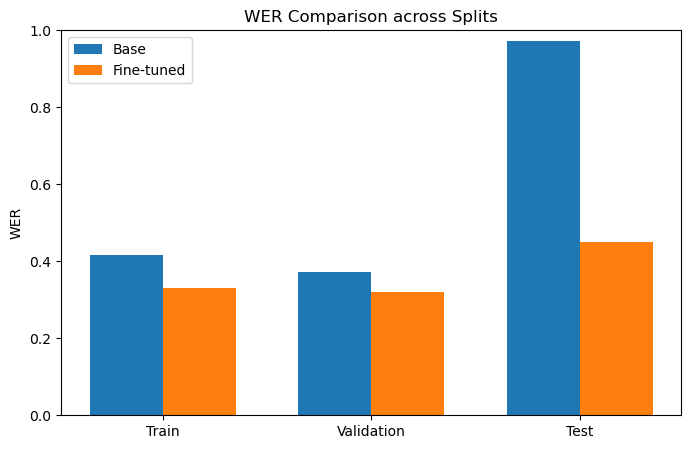

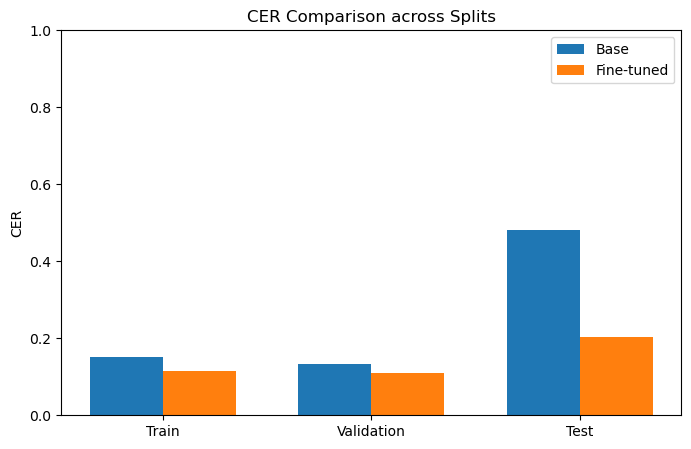

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Collect WER/CER results
splits = ["Train", "Validation", "Test"]
base_wer = [all_results[s]["base"]["wer"] for s in splits]
ft_wer   = [all_results[s]["finetuned"]["wer"] for s in splits]
base_cer = [all_results[s]["base"]["cer"] for s in splits]
ft_cer   = [all_results[s]["finetuned"]["cer"] for s in splits]

x = np.arange(len(splits))  # positions for groups
width = 0.35  # bar width

# Plot WER
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, base_wer, width, label="Base")
plt.bar(x + width/2, ft_wer, width, label="Fine-tuned")
plt.xticks(x, splits)
plt.ylabel("WER")
plt.title("WER Comparison across Splits")
plt.legend()
plt.ylim(0, 1)  # WER is between 0 and 1
plt.show()

# Plot CER
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, base_cer, width, label="Base")
plt.bar(x + width/2, ft_cer, width, label="Fine-tuned")
plt.xticks(x, splits)
plt.ylabel("CER")
plt.title("CER Comparison across Splits")
plt.legend()
plt.ylim(0, 1)  # CER is between 0 and 1
plt.show()

In [36]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
